# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

- UPDATE: I'm using the AVE split now

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
# from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=6
# SEED=7
# SEED=8
# SEED=2

#TODO: rename to result_p 
data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

lit_pcba_full_data_p = Path(f"/p/vast1/jones289/lit_pcba/lit_pcba_full_data")

In [2]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [3]:
# model_dict = {
#     "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
#     "hdbind-rp-molformer": ("HDBind+MolFormer-10k", green_color_pal[6]),
#     "hdbind-rp-molformer-100k": ("HDBind+MolFormer-100k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-10k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-100k": ("HDBind+ECFP-100k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]),    
#     "mlp-1024-1": ("MLP", blue_color_pal[7]),
#     "Vina": ("Vina", "salmon"),
# }
model_dict = {
    "molehd-bpe": ("MoleHD-BPE", rocket_color_pal[4]),
    "hdbind-rp-ecfp-1024-1": ("HDB-ECFP-10k", green_color_pal[6]),
    "hdbind-rp-ecfp-1024-1-100k": ("HDB-ECFP-100k", green_color_pal[6]),
    "hdbind-rp-molclr":  ("HDB-MolCLR-10k", green_color_pal[4]),
    "hdbind-rp-molclr-100k":  ("HDB-MolCLR-100k", green_color_pal[4]),
    "hdbind-rp-molformer": ("HDB-MolFormer-10k", green_color_pal[6]),
    "hdbind-rp-molformer-100k": ("HDB-MolFormer-100k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-100": ("HDBind+ECFP-100", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1k": ("HDBind+ECFP-1k", green_color_pal[6]),
#     "hdbind-rp-ecfp-1024-1-1m": ("HDBind+ECFP-1m", green_color_pal[6]),    
    "mlp-1024-1": ("MLP", blue_color_pal[7]),
    "Vina": ("Vina", "salmon"),
}

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [4]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
#     import pdb
#     pdb.set_trace()


    if y_score.squeeze().ndim == 2:
        enrich = float(compute_enrichment_factor(scores=y_score[:, 1], labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score[:, 1], y_true=y_true)
    else:
        enrich = float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p))
        roc = roc_auc_score(y_score=y_score, y_true=y_true)

    
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": enrich,            
           "roc": roc
           }


def aggregate_results(dataset, split, target_list=None):
    assert target_list is not None
#     import pdb
#     pdb.set_trace() 
    
#     if split == "random":
#         raise NotImplementedError # rename the files with "-random" to be consistent
        
    
    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
#                          "smiles": []
                        }


    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        

        data_path_list = list(data_p.glob(f"{model_name}.{dataset}-*-{split}*.pkl"))
#         print(f"{model_name}\t{dataset}\t{len(model_tup)}\t {len(data_path_list)}")

        
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):
            target = path.name.split(".")[1].split("-")[-2]
            print(target, path, model_name)

            if target in target_list or target_list == "all":
                pass
            else:
                continue
            
            model_data_dict = torch.load(path)
            
            # apparently we have duplicates in the test set...
            

            for seed in range(len(model_data_dict['trials'])):

    
                
                trial_dict = model_data_dict['trials'][seed]
            
            

                for p in [.01, .1]:

                    try:

                        
                        y_pred = trial_dict["y_pred"]
                        y_score = trial_dict["eta"]
                        
                        if model_name == "mlp":
                            y_score = y_score[:, 1]
                        
                        
#                         y_true = model_data_dict["y_test"]
                        y_true = trial_dict["y_true"]


                        # TODO: there are some issues with the number of smiles not lining up with the number of predictions/etc...
#                         import pdb
#                         pdb.set_trace()
                        print(f"y_pred: {y_pred.shape}\ty_score: {y_score.shape}\ty_true: {y_true.shape}")

                        
                        
                        metrics = compute_metrics(y_pred=y_pred, 
                                                  y_score=y_score, 
                                                  y_true=y_true,
                                                 p=p)

                        
                        
                        
                        
                        
                        
                        model_metric_dict["target"].append(target)
                        model_metric_dict["test_time"].append(trial_dict["test_time"])
                        model_metric_dict["enrich"].append(metrics["enrich"])
                        model_metric_dict["p"].append(p)
                        model_metric_dict["seed"].append(seed)
                        model_metric_dict["precision"].append(metrics["precision"])
                        model_metric_dict["recall"].append(metrics["recall"])
                        model_metric_dict["f1"].append(metrics["f1"])
                        model_metric_dict["model"].append(model_name)
#                         model_metric_dict["smiles"].append(model_data_dict["smiles_test"])
                        
                    except Exception as e:
                        print(e)


    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

#     import pdb
#     pdb.set_trace()
    return model_metric_df
        


# VINA result

In [5]:
from pathlib import Path

def load_lit_pcba_vina(nrows=None, split=None, target_list=None):

    
#     assert target_list is not None
    assert split is not None



    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")
    lig_map_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/")
#     /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/lig_rec/ # this path stores the map between conveyor and the original files
    
    path_list = [path for path in root_p.glob("*-actives.csv")]
#     print(len(path_list))

    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        
#         import pdb
#         pdb.set_trace()
        target = path.name.split(".")[0].split("-")[0]
#         print(target, target_list, (target in target_list))
        if target in target_list or target_list == "all":

        
            active_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-actives.csv")
            inactive_lig_map = pd.read_csv(lig_map_p / f"lig-{target}-inactives.csv")

            lig_map = pd.concat([active_lig_map, inactive_lig_map])

            
#             import pdb
#             pdb.set_trace()
            active_smiles_df = pd.read_csv(f"{lit_pcba_full_data_p}/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"{lit_pcba_full_data_p}/{target}/inactives.smi", delim_whitespace=True, header=None)
            smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])

            input_num_mols = smiles_df.shape[0]


            # Filter out the test set smiles strings

            test_smiles_path = f"/p/vast1/jones289/hd_results/{SEED}/hdbind-rp-molformer.lit-pcba-{target}-{split}.{SEED}.pkl"         
            print(test_smiles_path)
            test_smiles = torch.load(test_smiles_path)["smiles_test"]

#             import pdb
#             pdb.set_trace()

            # TODO: there's missing docking data?
            smiles_df = pd.merge(smiles_df, pd.DataFrame({0: test_smiles}), on=0)

            smiles_df = smiles_df.drop_duplicates(subset=[0])

            print(f"started with {input_num_mols} molecules for {target}, after merging with available docking data, have {smiles_df.shape[0]}/{len(test_smiles)} in test set")



    #         smiles_df = smiles_df[smiles_df[1].apply(lambda x: x in test_smiles.values)]





            target_df = pd.merge(lig_map, smiles_df, left_on=" name", right_on=1)

            # dock_score_cols = {idx: value for idx,value in enumerate(["file", "key", "Mesg", "Box/cx", "Box/cy", "Box/cz", "Box/dx", "Box/dy", "Box/dz", 
                        #    "ligName", 
                        #    "numPose", 
                        #    "scores/1", 
                        #    "scores/2", 
                        #    "scores/3", 
                        #    "scores/4", 
                        #    "scores/5", 
                        #    "scores/6", 
                        #    "scores/7", 
                        #    "scores/8", 
                        #    "scores/9", 
                        #    "scores/10", 
                        #    "Box/default"])}
            lig_id_col = 9
            active_dock_scores = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), header=None)
            active_dock_scores["label"] = [1] * len(active_dock_scores)

            inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
            inactive_dock_scores["label"] = [0] * len(inactive_dock_scores)
            dock_scores = pd.concat([active_dock_scores, inactive_dock_scores])


            dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)


            dock_scores = dock_scores.groupby(lig_id_col)[[lig_id_col, 'min_vina', 'label']].min().reset_index(drop=True)


            target_df = pd.merge(dock_scores, target_df, left_on=9, right_on=" name")

            target_df["target"] = [target] * len(target_df)

            # compute enrichment at 1% and 10%




    #         import pdb
    #         pdb.set_trace() 

            df_list.append(target_df)
        else:
            pass


    df = pd.concat(df_list)
    return df


In [6]:

def make_box_plot(enrich_1_df, enrich_10_df, dataset:str, split:str):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    
    enrich_f.suptitle(f"{dataset.upper()} ({split})")
    
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", 
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_1_ax)
    enrich_1_ax.set_title(f"Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

        
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich",
                  order=list(model_dict.keys()),
                  palette={key: value[1] for key, value in model_dict.items()},
                  ax=enrich_10_ax)

    enrich_10_ax.set_title(f"Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [model_dict[item.get_text()][0] for item in enrich_10_ax.get_xticklabels()]

    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()

    enrich_f.savefig(f"{dataset}-{split}-enrich.png", dpi=600, bbox_inches="tight")





def compute_model_metric_df(dataset, split, target_list=None):
    
    assert target_list is not None
    
    docking_df = load_lit_pcba_vina(target_list=target_list, split=split)

    
    model_metric_df = aggregate_results(dataset=dataset,
                                        split=split, target_list=target_list)
    

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_col='min_vina'
    label_col = "label"
    for target, target_df in docking_df.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df[label_col], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)
           
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    
    # take the average over the random seeds dimension for each combo of MODEL X TARGET X P
    grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()
    grp_df = grp_df.sort_values(by="model")
    
    
    for name, group in grp_df.groupby(["model", "p"]):
        print(name)
        print(group.describe())


    make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1],
             dataset=dataset, split=split)

    return model_metric_df


  0%|          | 0/15 [00:00<?, ?it/s]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-ave.5.pkl
started with 246069 molecules for PKM2, after merging with available docking data, have 43472/61516 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  7%|▋         | 1/15 [00:18<04:19, 18.56s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-ave.5.pkl
started with 296218 molecules for GBA, after merging with available docking data, have 51872/74054 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 13%|█▎        | 2/15 [00:32<03:27, 15.93s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-ave.5.pkl
started with 5596 molecules for ESR1_ago, after merging with available docking data, have 971/1398 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 20%|██        | 3/15 [00:33<01:50,  9.21s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-ave.5.pkl
started with 62937 molecules for MAPK1, after merging with available docking data, have 10778/15734 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 27%|██▋       | 4/15 [00:40<01:31,  8.32s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-ave.5.pkl
started with 356272 molecules for VDR, after merging with available docking data, have 47296/66800 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 33%|███▎      | 5/15 [00:47<01:18,  7.81s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-ave.5.pkl
started with 348742 molecules for KAT2A, after merging with available docking data, have 61847/87185 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 40%|████      | 6/15 [00:56<01:12,  8.02s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-ave.5.pkl
started with 145133 molecules for ALDH1, after merging with available docking data, have 19303/27212 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 47%|████▋     | 7/15 [01:03<01:03,  7.90s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-ave.5.pkl
started with 4247 molecules for TP53, after merging with available docking data, have 744/1061 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 53%|█████▎    | 8/15 [01:04<00:38,  5.52s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-ave.5.pkl
started with 5238 molecules for PPARG, after merging with available docking data, have 958/1308 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 60%|██████    | 9/15 [01:04<00:24,  4.01s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-ave.5.pkl
started with 312500 molecules for ADRB2, after merging with available docking data, have 55031/78124 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 67%|██████▋   | 10/15 [01:23<00:42,  8.43s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-ave.5.pkl
started with 33069 molecules for MTORC1, after merging with available docking data, have 6385/8267 in test set


/tmp/ipykernel_3590472/2535884398.py:88: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 73%|███████▎  | 11/15 [01:26<00:26,  6.72s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-ave.5.pkl
started with 269840 molecules for OPRK1, after merging with available docking data, have 47848/67460 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 80%|████████  | 12/15 [01:29<00:17,  5.69s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-ave.5.pkl
started with 362088 molecules for IDH1, after merging with available docking data, have 64232/90521 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 87%|████████▋ | 13/15 [02:06<00:30, 15.11s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-ave.5.pkl
started with 5050 molecules for ESR1_ant, after merging with available docking data, have 895/1262 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 93%|█████████▎| 14/15 [02:07<00:10, 10.84s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-ave.5.pkl
started with 355771 molecules for FEN1, after merging with available docking data, have 62823/88942 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-ave.5.pkl molehd-bpe
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true:


  7%|▋         | 1/15 [00:19<04:29, 19.25s/it]

ALDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1-ave.5.pkl molehd-bpe
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true:


 13%|█▎        | 2/15 [00:25<02:29, 11.49s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-ave.5.pkl molehd-bpe
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:25<01:16,  6.40s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-ave.5.pkl molehd-bpe
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (12


 27%|██▋       | 4/15 [00:25<00:43,  3.99s/it]

FEN1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1-ave.5.pkl molehd-bpe
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (


 33%|███▎      | 5/15 [00:48<01:46, 10.66s/it]

GBA /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA-ave.5.pkl molehd-bpe
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74


 40%|████      | 6/15 [01:06<01:58, 13.18s/it]

IDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1-ave.5.pkl molehd-bpe
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (


 47%|████▋     | 7/15 [01:29<02:12, 16.52s/it]

KAT2A /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A-ave.5.pkl molehd-bpe
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true:


 53%|█████▎    | 8/15 [01:52<02:08, 18.41s/it]

MAPK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-ave.5.pkl molehd-bpe
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true:


 60%|██████    | 9/15 [01:55<01:22, 13.72s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-ave.5.pkl molehd-bpe
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (826


 67%|██████▋   | 10/15 [01:57<00:50, 10.02s/it]

OPRK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1-ave.5.pkl molehd-bpe
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true:


 73%|███████▎  | 11/15 [02:14<00:48, 12.04s/it]

PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-ave.5.pkl molehd-bpe
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (


 80%|████████  | 12/15 [02:29<00:38, 12.93s/it]

PPARG /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-ave.5.pkl molehd-bpe
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:29<00:18,  9.11s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-ave.5.pkl molehd-bpe
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)



 93%|█████████▎| 14/15 [02:29<00:06,  6.44s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR-ave.5.pkl molehd-bpe
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_sco


  7%|▋         | 1/15 [00:18<04:14, 18.17s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_sco


 13%|█▎        | 2/15 [00:23<02:15, 10.45s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:23<01:09,  5.80s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)



 27%|██▋       | 4/15 [00:23<00:39,  3.61s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942


 33%|███▎      | 5/15 [00:44<01:38,  9.84s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: 


 40%|████      | 6/15 [01:02<01:53, 12.63s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score


 47%|████▋     | 7/15 [01:22<01:59, 14.96s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_sco


 53%|█████▎    | 8/15 [01:41<01:53, 16.24s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_sco


 60%|██████    | 9/15 [01:44<01:12, 12.07s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (


 67%|██████▋   | 10/15 [01:46<00:44,  8.87s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (6746


 73%|███████▎  | 11/15 [02:00<00:42, 10.52s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score


 80%|████████  | 12/15 [02:13<00:34, 11.35s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:13<00:16,  8.01s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)



 93%|█████████▎| 14/15 [02:14<00:05,  5.67s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124


  7%|▋         | 1/15 [00:18<04:12, 18.03s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212


 13%|█▎        | 2/15 [00:23<02:17, 10.57s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:23<01:11,  5.93s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1


 27%|██▋       | 4/15 [00:24<00:41,  3.74s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_scor


 33%|███▎      | 5/15 [00:43<01:33,  9.39s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-GBA-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)


 40%|████      | 6/15 [01:00<01:46, 11.84s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 


 47%|████▋     | 7/15 [01:22<02:02, 15.29s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185


 53%|█████▎    | 8/15 [01:45<02:03, 17.61s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734


 60%|██████    | 9/15 [01:48<01:19, 13.19s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)


 67%|██████▋   | 10/15 [01:50<00:48,  9.67s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1


 73%|███████▎  | 11/15 [02:07<00:47, 11.86s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 


 80%|████████  | 12/15 [02:22<00:38, 12.89s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:22<00:18,  9.10s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-TP53-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred


 93%|█████████▎| 14/15 [02:23<00:06,  6.45s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-VDR-ave.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_sco


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molclr
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124


  7%|▋         | 1/15 [00:19<04:35, 19.68s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molclr
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212


 13%|█▎        | 2/15 [00:25<02:29, 11.52s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molclr
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:25<01:16,  6.41s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molclr
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	


 27%|██▋       | 4/15 [00:26<00:44,  4.00s/it]

FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molclr
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 


 33%|███▎      | 5/15 [00:48<01:47, 10.71s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-GBA-ave.5.pkl hdbind-rp-molclr
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)


 40%|████      | 6/15 [01:07<02:00, 13.41s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molclr
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 


 47%|████▋     | 7/15 [01:31<02:14, 16.79s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molclr
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185


 53%|█████▎    | 8/15 [01:54<02:11, 18.81s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molclr
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734


 60%|██████    | 9/15 [01:57<01:24, 14.05s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molclr
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y


 67%|██████▋   | 10/15 [01:59<00:51, 10.23s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molclr
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460


 73%|███████▎  | 11/15 [02:16<00:49, 12.29s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molclr
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 


 80%|████████  | 12/15 [02:32<00:40, 13.55s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molclr
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:33<00:19,  9.55s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-TP53-ave.5.pkl hdbind-rp-molclr
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score:


 93%|█████████▎| 14/15 [02:33<00:06,  6.76s/it]

VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-VDR-ave.5.pkl hdbind-rp-molclr
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_sco


  7%|▋         | 1/15 [00:19<04:35, 19.66s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_sco


 13%|█▎        | 2/15 [00:25<02:26, 11.27s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:25<01:15,  6.29s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: 


 27%|██▋       | 4/15 [00:25<00:43,  3.95s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942,


 33%|███▎      | 5/15 [00:50<01:54, 11.48s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-GBA-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: 


 40%|████      | 6/15 [01:11<02:11, 14.60s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score


 47%|████▋     | 7/15 [01:36<02:23, 17.91s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_sco


 53%|█████▎    | 8/15 [01:59<02:17, 19.70s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_sco


 60%|██████    | 9/15 [02:03<01:27, 14.65s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (


 67%|██████▋   | 10/15 [02:05<00:53, 10.72s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_sco


 73%|███████▎  | 11/15 [02:22<00:51, 12.83s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score


 80%|████████  | 12/15 [02:38<00:41, 13.71s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:38<00:19,  9.70s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-TP53-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1


 93%|█████████▎| 14/15 [02:39<00:06,  6.90s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-VDR-ave.5.pkl hdbind-rp-molclr-100k
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molformer
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: 


  7%|▋         | 1/15 [00:20<04:51, 20.82s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molformer
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: 


 13%|█▎        | 2/15 [00:27<02:40, 12.37s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molformer
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:27<01:22,  6.87s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molformer
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (126


 27%|██▋       | 4/15 [00:27<00:47,  4.28s/it]

FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molformer
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (8


 33%|███▎      | 5/15 [00:50<01:49, 10.99s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-ave.5.pkl hdbind-rp-molformer
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (740


 40%|████      | 6/15 [01:10<02:06, 14.02s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molformer
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (9


 47%|████▋     | 7/15 [01:34<02:16, 17.11s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molformer
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: 


 53%|█████▎    | 8/15 [01:55<02:10, 18.60s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molformer
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: 


 60%|██████    | 9/15 [01:59<01:23, 13.84s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molformer
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267


 67%|██████▋   | 10/15 [02:01<00:50, 10.09s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molformer
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1


 73%|███████▎  | 11/15 [02:18<00:49, 12.48s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molformer
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (6


 80%|████████  | 12/15 [02:34<00:40, 13.51s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molformer
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)



 87%|████████▋ | 13/15 [02:35<00:19,  9.51s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-ave.5.pkl hdbind-rp-molformer
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)



 93%|█████████▎| 14/15 [02:35<00:06,  6.72s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-ave.5.pkl hdbind-rp-molformer
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (6


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ADRB2-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)	y_score: (78124, 1)	y_true: (78124, 1)
y_pred: (78124, 1)


  7%|▋         | 1/15 [00:21<05:03, 21.65s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ALDH1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)	y_score: (27212, 1)	y_true: (27212, 1)
y_pred: (27212, 1)


 13%|█▎        | 2/15 [00:28<02:47, 12.88s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ago-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)



 20%|██        | 3/15 [00:28<01:26,  7.19s/it]

y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
y_pred: (1398, 1)	y_score: (1398, 1)	y_true: (1398, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ant-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_


 27%|██▋       | 4/15 [00:29<00:49,  4.50s/it]

y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
y_pred: (1262, 1)	y_score: (1262, 1)	y_true: (1262, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-FEN1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)	y_true: (88942, 1)
y_pred: (88942, 1)	y_score: (88942, 1)


 33%|███▎      | 5/15 [00:51<01:51, 11.10s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-GBA-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_score: (74054, 1)	y_true: (74054, 1)
y_pred: (74054, 1)	y_s


 40%|████      | 6/15 [01:10<02:01, 13.54s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-IDH1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y_score: (90521, 1)	y_true: (90521, 1)
y_pred: (90521, 1)	y


 47%|████▋     | 7/15 [01:32<02:10, 16.30s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-KAT2A-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)	y_score: (87185, 1)	y_true: (87185, 1)
y_pred: (87185, 1)


 53%|█████▎    | 8/15 [01:54<02:07, 18.15s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MAPK1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
y_pred: (15734, 1)


 60%|██████    | 9/15 [01:57<01:21, 13.59s/it]

y_pred: (15734, 1)	y_score: (15734, 1)	y_true: (15734, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MTORC1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_p


 67%|██████▋   | 10/15 [01:59<00:49,  9.98s/it]

y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
y_pred: (8267, 1)	y_score: (8267, 1)	y_true: (8267, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-OPRK1-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_sco


 73%|███████▎  | 11/15 [02:16<00:48, 12.17s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PKM2-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y_score: (61516, 1)	y_true: (61516, 1)
y_pred: (61516, 1)	y


 80%|████████  | 12/15 [02:32<00:39, 13.11s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PPARG-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: 


 87%|████████▋ | 13/15 [02:32<00:18,  9.27s/it]

y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
y_pred: (1308, 1)	y_score: (1308, 1)	y_true: (1308, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-TP53-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)



 93%|█████████▎| 14/15 [02:33<00:06,  6.58s/it]

y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
y_pred: (1061, 1)	y_score: (1061, 1)	y_true: (1061, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-VDR-ave.5.pkl hdbind-rp-molformer-100k
y_pred: (66800, 1)	y_score: (66800, 1)	y_true: (66800, 1)
y_pred: (


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2-ave.5.pkl mlp-1024-1
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score: torch.Size([78124, 2])	y_true: torch.Size([78124])
y_pred: torch.Size([78124])	y_score:


  7%|▋         | 1/15 [01:25<20:03, 85.98s/it]

ALDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score: torch.Size([27212, 2])	y_true: torch.Size([27212])
y_pred: torch.Size([27212])	y_score:


 13%|█▎        | 2/15 [01:51<10:55, 50.41s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_


 20%|██        | 3/15 [01:52<05:33, 27.80s/it]

y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
y_pred: torch.Size([1398])	y_score: torch.Size([1398, 2])	y_true: torch.Size([1398])
ESR1_ant /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_


 27%|██▋       | 4/15 [01:53<03:08, 17.13s/it]

y_pred: torch.Size([1262])	y_score: torch.Size([1262, 2])	y_true: torch.Size([1262])
FEN1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torch.Size([88942, 2])	y_true: torch.Size([88942])
y_pred: torch.Size([88942])	y_score: torc


 33%|███▎      | 5/15 [03:32<07:48, 46.87s/it]

GBA /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA-ave.5.pkl mlp-1024-1
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: torch.Size([74054, 2])	y_true: torch.Size([74054])
y_pred: torch.Size([74054])	y_score: tor


 40%|████      | 6/15 [04:54<08:48, 58.68s/it]

IDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: torch.Size([90521, 2])	y_true: torch.Size([90521])
y_pred: torch.Size([90521])	y_score: t


 47%|████▋     | 7/15 [06:37<09:44, 73.07s/it]

KAT2A /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A-ave.5.pkl mlp-1024-1
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score: torch.Size([87185, 2])	y_true: torch.Size([87185])
y_pred: torch.Size([87185])	y_score:


 53%|█████▎    | 8/15 [08:16<09:30, 81.44s/it]

MAPK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score: torch.Size([15734, 2])	y_true: torch.Size([15734])
y_pred: torch.Size([15734])	y_score:


 60%|██████    | 9/15 [08:30<06:01, 60.30s/it]

MTORC1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true: torch.Size([8267])
y_pred: torch.Size([8267])	y_score: torch.Size([8267, 2])	y_true


 67%|██████▋   | 10/15 [08:36<03:38, 43.63s/it]

OPRK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1-ave.5.pkl mlp-1024-1
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score:


 73%|███████▎  | 11/15 [09:54<03:35, 53.98s/it]

PKM2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2-ave.5.pkl mlp-1024-1
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: torch.Size([61516, 2])	y_true: torch.Size([61516])
y_pred: torch.Size([61516])	y_score: t


 80%|████████  | 12/15 [11:01<02:54, 58.13s/it]

PPARG /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: 


 87%|████████▋ | 13/15 [11:01<01:21, 40.61s/it]

y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
y_pred: torch.Size([1308])	y_score: torch.Size([1308, 2])	y_true: torch.Size([1308])
TP53 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53-ave.5.pkl mlp-1024-1
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: to


 93%|█████████▎| 14/15 [11:02<00:28, 28.55s/it]

y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
y_pred: torch.Size([1061])	y_score: torch.Size([1061, 2])	y_true: torch.Size([1061])
VDR /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR-ave.5.pkl mlp-1024-1
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([66800, 2])	y_true: torch.Size([66800])
y_pred: torch.Size([66800])	y_score: torch.Size([668


 89%|████████▉ | 8/9 [31:46<05:51, 351.21s/it]
0it [00:00, ?it/s]
100%|██████████| 9/9 [31:46<00:00, 211.82s/it]


('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   0.626063
std     0.00   0.932153
min     0.01   0.000000
25%     0.01   0.000000
50%     0.01   0.000000
75%     0.01   1.185305
max     0.01   3.122324
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.382682
std    2.872975e-17   0.958248
min    1.000000e-01   0.000000
25%    1.000000e-01   0.917282
50%    1.000000e-01   1.304161
75%    1.000000e-01   1.651117
max    1.000000e-01   3.332918
('hdbind-rp-ecfp-1024-1', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   5.351097
std     0.00   6.582956
min     0.01   0.000000
25%     0.01   1.692604
50%     0.01   3.553589
75%     0.01   5.517831
max     0.01  25.200957
('hdbind-rp-ecfp-1024-1', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   2.857164
std    2.872975e-17   1.735331
min    1.000000e-01   0.166667
25%    1.000000e-01   1.801959
50%    1.00

/usr/workspace/wsa/jones289/miniconda3/envs/dtra_reactivator/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


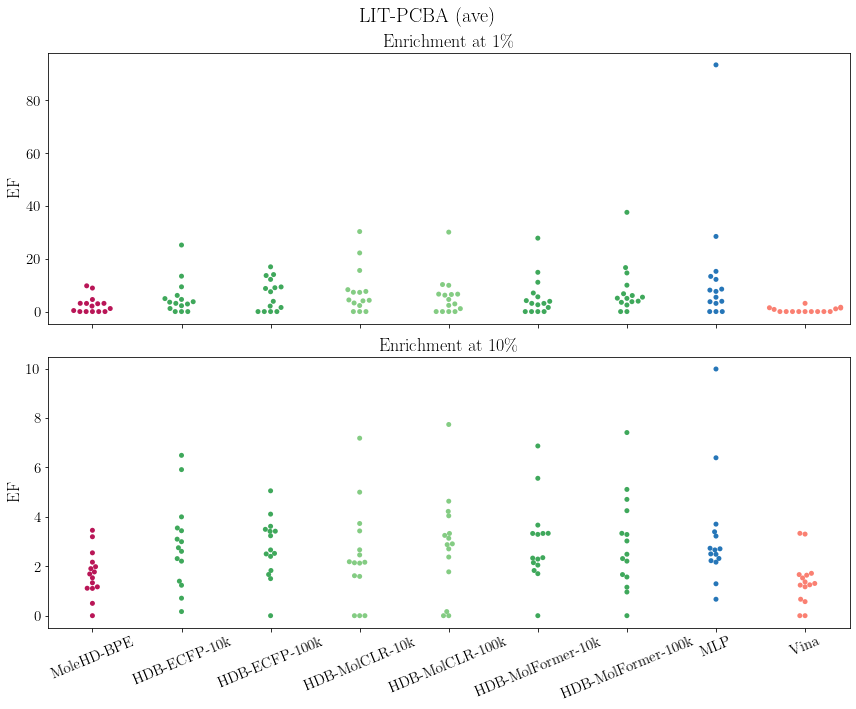

In [7]:
litpcba_df = compute_model_metric_df(dataset="lit-pcba", split="ave", target_list="all")

  0%|          | 0/15 [00:00<?, ?it/s]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-random.5.pkl
started with 246069 molecules for PKM2, after merging with available docking data, have 43394/61518 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  7%|▋         | 1/15 [00:16<03:45, 16.12s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-random.5.pkl
started with 296218 molecules for GBA, after merging with available docking data, have 51851/74055 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 13%|█▎        | 2/15 [00:29<03:08, 14.48s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-random.5.pkl
started with 5596 molecules for ESR1_ago, after merging with available docking data, have 993/1399 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 20%|██        | 3/15 [00:30<01:39,  8.25s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-random.5.pkl
started with 62937 molecules for MAPK1, after merging with available docking data, have 10739/15735 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 27%|██▋       | 4/15 [00:36<01:23,  7.56s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-random.5.pkl
started with 356272 molecules for VDR, after merging with available docking data, have 47208/66801 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 33%|███▎      | 5/15 [00:43<01:12,  7.23s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-random.5.pkl
started with 348742 molecules for KAT2A, after merging with available docking data, have 61615/87186 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 40%|████      | 6/15 [00:52<01:09,  7.77s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-random.5.pkl
started with 145133 molecules for ALDH1, after merging with available docking data, have 19193/27213 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 47%|████▋     | 7/15 [01:00<01:04,  8.07s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-random.5.pkl
started with 4247 molecules for TP53, after merging with available docking data, have 764/1062 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 53%|█████▎    | 8/15 [01:01<00:39,  5.64s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-random.5.pkl
started with 5238 molecules for PPARG, after merging with available docking data, have 955/1310 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 60%|██████    | 9/15 [01:02<00:24,  4.10s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-random.5.pkl
started with 312500 molecules for ADRB2, after merging with available docking data, have 54953/78125 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 67%|██████▋   | 10/15 [01:20<00:42,  8.55s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-random.5.pkl
started with 33069 molecules for MTORC1, after merging with available docking data, have 6450/8268 in test set


/tmp/ipykernel_3590472/2535884398.py:88: DtypeWarning: Columns (12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  inactive_dock_scores = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), header=None)
/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 73%|███████▎  | 11/15 [01:23<00:27,  6.79s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-random.5.pkl
started with 269840 molecules for OPRK1, after merging with available docking data, have 47787/67460 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 80%|████████  | 12/15 [01:26<00:17,  5.74s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-random.5.pkl
started with 362088 molecules for IDH1, after merging with available docking data, have 64088/90522 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 87%|████████▋ | 13/15 [02:04<00:30, 15.34s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-random.5.pkl
started with 5050 molecules for ESR1_ant, after merging with available docking data, have 886/1263 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
 93%|█████████▎| 14/15 [02:05<00:11, 11.01s/it]

/p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-random.5.pkl
started with 355771 molecules for FEN1, after merging with available docking data, have 62951/88943 in test set


/tmp/ipykernel_3590472/2535884398.py:93: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dock_scores['min_vina'] = dock_scores[dock_scores.columns[11:21]].min(axis=1)
  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ADRB2-random.5.pkl molehd-bpe
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_tr


  7%|▋         | 1/15 [00:19<04:35, 19.65s/it]

ALDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ALDH1-random.5.pkl molehd-bpe
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_tr


 13%|█▎        | 2/15 [00:25<02:33, 11.79s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ago-random.5.pkl molehd-bpe
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:26<01:18,  6.55s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-ESR1_ant-random.5.pkl molehd-bpe
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: 


 27%|██▋       | 4/15 [00:26<00:44,  4.09s/it]

FEN1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-FEN1-random.5.pkl molehd-bpe
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true


 33%|███▎      | 5/15 [00:49<01:47, 10.76s/it]

GBA /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-GBA-random.5.pkl molehd-bpe
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: 


 40%|████      | 6/15 [01:07<02:00, 13.41s/it]

IDH1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-IDH1-random.5.pkl molehd-bpe
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true


 47%|████▋     | 7/15 [01:30<02:11, 16.50s/it]

KAT2A /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-KAT2A-random.5.pkl molehd-bpe
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_tr


 53%|█████▎    | 8/15 [01:53<02:09, 18.44s/it]

MAPK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MAPK1-random.5.pkl molehd-bpe
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_tr


 60%|██████    | 9/15 [01:56<01:22, 13.80s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-MTORC1-random.5.pkl molehd-bpe
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (


 67%|██████▋   | 10/15 [01:58<00:50, 10.10s/it]

OPRK1 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-OPRK1-random.5.pkl molehd-bpe
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_tr


 73%|███████▎  | 11/15 [02:15<00:49, 12.34s/it]

PKM2 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PKM2-random.5.pkl molehd-bpe
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true


 80%|████████  | 12/15 [02:31<00:40, 13.34s/it]

PPARG /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-PPARG-random.5.pkl molehd-bpe
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:31<00:18,  9.40s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-TP53-random.5.pkl molehd-bpe
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)



 93%|█████████▎| 14/15 [02:32<00:06,  6.64s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/molehd-bpe.lit-pcba-VDR-random.5.pkl molehd-bpe
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_


  7%|▋         | 1/15 [00:20<04:45, 20.36s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_


 13%|█▎        | 2/15 [00:26<02:37, 12.08s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:26<01:20,  6.72s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pre


 27%|██▋       | 4/15 [00:27<00:46,  4.19s/it]

FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_sc


 33%|███▎      | 5/15 [00:50<01:49, 10.91s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_scor


 40%|████      | 6/15 [01:09<02:03, 13.70s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_sc


 47%|████▋     | 7/15 [01:32<02:15, 16.98s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_


 53%|█████▎    | 8/15 [01:56<02:13, 19.06s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_


 60%|██████    | 9/15 [01:59<01:25, 14.17s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred


 67%|██████▋   | 10/15 [02:01<00:51, 10.34s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_


 73%|███████▎  | 11/15 [02:18<00:49, 12.47s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_sc


 80%|████████  | 12/15 [02:34<00:40, 13.37s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:34<00:18,  9.42s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)



 93%|█████████▎| 14/15 [02:35<00:06,  6.66s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ADRB2-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78


  7%|▋         | 1/15 [00:19<04:38, 19.90s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ALDH1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27


 13%|█▎        | 2/15 [00:26<02:34, 11.90s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399


 20%|██        | 3/15 [00:26<01:20,  6.67s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263


 27%|██▋       | 4/15 [00:27<00:46,  4.22s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-FEN1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: 


 33%|███▎      | 5/15 [00:49<01:48, 10.83s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-GBA-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055,


 40%|████      | 6/15 [01:08<02:02, 13.63s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-IDH1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (9052


 47%|████▋     | 7/15 [01:31<02:12, 16.61s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-KAT2A-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87


 53%|█████▎    | 8/15 [01:52<02:06, 18.09s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MAPK1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15


 60%|██████    | 9/15 [01:55<01:20, 13.40s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-MTORC1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268,


 67%|██████▋   | 10/15 [01:57<00:49,  9.84s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-OPRK1-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67


 73%|███████▎  | 11/15 [02:12<00:45, 11.41s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PKM2-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (6151


 80%|████████  | 12/15 [02:26<00:36, 12.01s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-PPARG-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:26<00:17,  8.50s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-TP53-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_p


 93%|█████████▎| 14/15 [02:26<00:06,  6.04s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1-100k.lit-pcba-VDR-random.5.pkl hdbind-rp-ecfp-1024-1-100k
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molclr
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78


  7%|▋         | 1/15 [00:19<04:33, 19.51s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molclr
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27


 13%|█▎        | 2/15 [00:25<02:27, 11.37s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molclr
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:25<01:15,  6.33s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molclr
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 


 27%|██▋       | 4/15 [00:25<00:43,  3.95s/it]

FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-FEN1-random.5.pkl hdbind-rp-molclr
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (8894


 33%|███▎      | 5/15 [00:46<01:41, 10.16s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-GBA-random.5.pkl hdbind-rp-molclr
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055,


 40%|████      | 6/15 [01:04<01:52, 12.54s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-IDH1-random.5.pkl hdbind-rp-molclr
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (9052


 47%|████▋     | 7/15 [01:27<02:08, 16.00s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molclr
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87


 53%|█████▎    | 8/15 [01:50<02:07, 18.28s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molclr
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15


 60%|██████    | 9/15 [01:53<01:21, 13.62s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molclr
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1


 67%|██████▋   | 10/15 [01:55<00:49,  9.90s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molclr
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67


 73%|███████▎  | 11/15 [02:12<00:48, 12.06s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PKM2-random.5.pkl hdbind-rp-molclr
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (6151


 80%|████████  | 12/15 [02:26<00:38, 12.76s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-PPARG-random.5.pkl hdbind-rp-molclr
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:27<00:17,  8.99s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-TP53-random.5.pkl hdbind-rp-molclr
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)



 93%|█████████▎| 14/15 [02:27<00:06,  6.35s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molclr.lit-pcba-VDR-random.5.pkl hdbind-rp-molclr
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (6


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molclr-100k
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_


  7%|▋         | 1/15 [00:20<04:50, 20.78s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molclr-100k
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_


 13%|█▎        | 2/15 [00:27<02:40, 12.37s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molclr-100k
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pre


 20%|██        | 3/15 [00:27<01:23,  6.93s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molclr-100k
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)



 27%|██▋       | 4/15 [00:28<00:48,  4.39s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-FEN1-random.5.pkl hdbind-rp-molclr-100k
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_


 33%|███▎      | 5/15 [00:51<01:53, 11.38s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-GBA-random.5.pkl hdbind-rp-molclr-100k
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_scor


 40%|████      | 6/15 [01:09<02:02, 13.58s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-IDH1-random.5.pkl hdbind-rp-molclr-100k
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_sc


 47%|████▋     | 7/15 [01:30<02:08, 16.02s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molclr-100k
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_


 53%|█████▎    | 8/15 [01:54<02:08, 18.36s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molclr-100k
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_


 60%|██████    | 9/15 [01:57<01:22, 13.70s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molclr-100k
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (


 67%|██████▋   | 10/15 [01:59<00:50, 10.00s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molclr-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score:


 73%|███████▎  | 11/15 [02:17<00:50, 12.54s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-PKM2-random.5.pkl hdbind-rp-molclr-100k
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_sc


 80%|████████  | 12/15 [02:34<00:41, 13.85s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-PPARG-random.5.pkl hdbind-rp-molclr-100k
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:34<00:19,  9.78s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-TP53-random.5.pkl hdbind-rp-molclr-100k
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062


 93%|█████████▎| 14/15 [02:35<00:06,  6.94s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molclr-100k.lit-pcba-VDR-random.5.pkl hdbind-rp-molclr-100k
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molformer
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_scor


  7%|▋         | 1/15 [00:21<05:02, 21.61s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molformer
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_scor


 13%|█▎        | 2/15 [00:28<02:48, 12.93s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molformer
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)



 20%|██        | 3/15 [00:28<01:26,  7.19s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molformer
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (


 27%|██▋       | 4/15 [00:29<00:49,  4.48s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1-random.5.pkl hdbind-rp-molformer
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 


 33%|███▎      | 5/15 [00:53<01:56, 11.64s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA-random.5.pkl hdbind-rp-molformer
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (


 40%|████      | 6/15 [01:13<02:09, 14.39s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1-random.5.pkl hdbind-rp-molformer
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score:


 47%|████▋     | 7/15 [01:37<02:20, 17.58s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molformer
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_scor


 53%|█████▎    | 8/15 [02:00<02:15, 19.35s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molformer
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_scor


 60%|██████    | 9/15 [02:04<01:26, 14.41s/it]

y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molformer
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8


 67%|██████▋   | 10/15 [02:05<00:52, 10.52s/it]

y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molformer
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: 


 73%|███████▎  | 11/15 [02:23<00:50, 12.61s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2-random.5.pkl hdbind-rp-molformer
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score:


 80%|████████  | 12/15 [02:38<00:40, 13.57s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG-random.5.pkl hdbind-rp-molformer
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:39<00:19,  9.56s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53-random.5.pkl hdbind-rp-molformer
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)



 93%|█████████▎| 14/15 [02:39<00:06,  6.75s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR-random.5.pkl hdbind-rp-molformer
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (6


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ADRB2-random.5.pkl hdbind-rp-molformer-100k
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125, 1)	y_score: (78125, 1)	y_true: (78125, 1)
y_pred: (78125,


  7%|▋         | 1/15 [00:20<04:43, 20.27s/it]

ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ALDH1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213, 1)	y_score: (27213, 1)	y_true: (27213, 1)
y_pred: (27213,


 13%|█▎        | 2/15 [00:27<02:40, 12.34s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ago-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)


 20%|██        | 3/15 [00:27<01:23,  6.92s/it]

y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
y_pred: (1399, 1)	y_score: (1399, 1)	y_true: (1399, 1)
ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-ESR1_ant-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)


 27%|██▋       | 4/15 [00:27<00:47,  4.36s/it]

y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
y_pred: (1263, 1)	y_score: (1263, 1)	y_true: (1263, 1)
FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-FEN1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (88943, 1)	y_true: (88943, 1)
y_pred: (88943, 1)	y_score: (889


 33%|███▎      | 5/15 [00:50<01:49, 10.98s/it]

GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-GBA-random.5.pkl hdbind-rp-molformer-100k
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	y_score: (74055, 1)	y_true: (74055, 1)
y_pred: (74055, 1)	


 40%|████      | 6/15 [01:09<02:04, 13.81s/it]

IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-IDH1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1)	y_score: (90522, 1)	y_true: (90522, 1)
y_pred: (90522, 1


 47%|████▋     | 7/15 [01:33<02:16, 17.04s/it]

KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-KAT2A-random.5.pkl hdbind-rp-molformer-100k
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186, 1)	y_score: (87186, 1)	y_true: (87186, 1)
y_pred: (87186,


 53%|█████▎    | 8/15 [01:56<02:12, 18.94s/it]

MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MAPK1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735, 1)	y_score: (15735, 1)	y_true: (15735, 1)
y_pred: (15735,


 60%|██████    | 9/15 [02:00<01:24, 14.15s/it]

MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-MTORC1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_pred: (8268, 1)	y_score: (8268, 1)	y_true: (8268, 1)
y_p


 67%|██████▋   | 10/15 [02:02<00:51, 10.37s/it]

OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-OPRK1-random.5.pkl hdbind-rp-molformer-100k
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460, 1)	y_score: (67460, 1)	y_true: (67460, 1)
y_pred: (67460,


 73%|███████▎  | 11/15 [02:19<00:49, 12.48s/it]

PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PKM2-random.5.pkl hdbind-rp-molformer-100k
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1)	y_score: (61518, 1)	y_true: (61518, 1)
y_pred: (61518, 1


 80%|████████  | 12/15 [02:34<00:40, 13.34s/it]

PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-PPARG-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)



 87%|████████▋ | 13/15 [02:35<00:18,  9.44s/it]

y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
y_pred: (1310, 1)	y_score: (1310, 1)	y_true: (1310, 1)
TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-TP53-random.5.pkl hdbind-rp-molformer-100k
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred:


 93%|█████████▎| 14/15 [02:35<00:06,  6.73s/it]

y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
y_pred: (1062, 1)	y_score: (1062, 1)	y_true: (1062, 1)
VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer-100k.lit-pcba-VDR-random.5.pkl hdbind-rp-molformer-100k
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: (66801, 1)	y_true: (66801, 1)
y_pred: (66801, 1)	y_score: 


  0%|          | 0/15 [00:00<?, ?it/s]

ADRB2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ADRB2-random.5.pkl mlp-1024-1
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_score: torch.Size([78125, 2])	y_true: torch.Size([78125])
y_pred: torch.Size([78125])	y_sco


  7%|▋         | 1/15 [01:31<21:17, 91.26s/it]

ALDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ALDH1-random.5.pkl mlp-1024-1
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_score: torch.Size([27213, 2])	y_true: torch.Size([27213])
y_pred: torch.Size([27213])	y_sco


 13%|█▎        | 2/15 [02:00<11:50, 54.68s/it]

ESR1_ago /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ago-random.5.pkl mlp-1024-1
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])


 20%|██        | 3/15 [02:01<06:01, 30.16s/it]

y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
y_pred: torch.Size([1399])	y_score: torch.Size([1399, 2])	y_true: torch.Size([1399])
ESR1_ant /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-ESR1_ant-random.5.pkl mlp-1024-1
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])	y_true: torch.Size([1263])
y_pred: torch.Size([1263])	y_score: torch.Size([1263, 2])


 27%|██▋       | 4/15 [02:02<03:24, 18.55s/it]

FEN1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-FEN1-random.5.pkl mlp-1024-1
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score: torch.Size([88943, 2])	y_true: torch.Size([88943])
y_pred: torch.Size([88943])	y_score


 33%|███▎      | 5/15 [03:47<08:19, 49.98s/it]

GBA /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-GBA-random.5.pkl mlp-1024-1
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: torch.Size([74055, 2])	y_true: torch.Size([74055])
y_pred: torch.Size([74055])	y_score: 


 40%|████      | 6/15 [05:13<09:18, 62.06s/it]

IDH1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-IDH1-random.5.pkl mlp-1024-1
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score: torch.Size([90522, 2])	y_true: torch.Size([90522])
y_pred: torch.Size([90522])	y_score


 47%|████▋     | 7/15 [07:03<10:23, 77.96s/it]

KAT2A /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-KAT2A-random.5.pkl mlp-1024-1
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_score: torch.Size([87186, 2])	y_true: torch.Size([87186])
y_pred: torch.Size([87186])	y_sco


 53%|█████▎    | 8/15 [08:43<09:52, 84.69s/it]

MAPK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MAPK1-random.5.pkl mlp-1024-1
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_score: torch.Size([15735, 2])	y_true: torch.Size([15735])
y_pred: torch.Size([15735])	y_sco


 60%|██████    | 9/15 [08:57<06:15, 62.63s/it]

MTORC1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-MTORC1-random.5.pkl mlp-1024-1
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_true: torch.Size([8268])
y_pred: torch.Size([8268])	y_score: torch.Size([8268, 2])	y_t


 67%|██████▋   | 10/15 [09:03<03:46, 45.36s/it]

OPRK1 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-OPRK1-random.5.pkl mlp-1024-1
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_score: torch.Size([67460, 2])	y_true: torch.Size([67460])
y_pred: torch.Size([67460])	y_sco


 73%|███████▎  | 11/15 [10:17<03:35, 53.98s/it]

PKM2 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PKM2-random.5.pkl mlp-1024-1
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score: torch.Size([61518, 2])	y_true: torch.Size([61518])
y_pred: torch.Size([61518])	y_score


 80%|████████  | 12/15 [11:25<02:55, 58.36s/it]

PPARG /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-PPARG-random.5.pkl mlp-1024-1
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_tru


 87%|████████▋ | 13/15 [11:26<01:21, 40.80s/it]

y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
y_pred: torch.Size([1310])	y_score: torch.Size([1310, 2])	y_true: torch.Size([1310])
TP53 /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-TP53-random.5.pkl mlp-1024-1
y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true: torch.Size([1062])
y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true: torch.Size([1062])
y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true:


 93%|█████████▎| 14/15 [11:26<00:28, 28.72s/it]

y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true: torch.Size([1062])
y_pred: torch.Size([1062])	y_score: torch.Size([1062, 2])	y_true: torch.Size([1062])
VDR /p/vast1/jones289/hd_results/5/mlp-1024-1.lit-pcba-VDR-random.5.pkl mlp-1024-1
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.Size([66801, 2])	y_true: torch.Size([66801])
y_pred: torch.Size([66801])	y_score: torch.


 89%|████████▉ | 8/9 [32:36<06:00, 360.83s/it]
0it [00:00, ?it/s]
100%|██████████| 9/9 [32:36<00:00, 217.44s/it]


('Vina', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01   2.670534
std     0.00   6.290931
min     0.01   0.000000
25%     0.01   0.000000
50%     0.01   0.744817
75%     0.01   2.120516
max     0.01  24.825000
('Vina', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   1.601221
std    2.872975e-17   1.238805
min    1.000000e-01   0.000000
25%    1.000000e-01   1.110636
50%    1.000000e-01   1.362666
75%    1.000000e-01   1.885601
max    1.000000e-01   4.965000
('hdbind-rp-ecfp-1024-1', 0.01)
           p     enrich
count  15.00  15.000000
mean    0.01  25.051066
std     0.00  22.014785
min     0.01   0.000000
25%     0.01  10.412107
50%     0.01  21.722869
75%     0.01  28.723899
max     0.01  83.283951
('hdbind-rp-ecfp-1024-1', 0.1)
                  p     enrich
count  1.500000e+01  15.000000
mean   1.000000e-01   5.042508
std    2.872975e-17   2.378700
min    1.000000e-01   0.000000
25%    1.000000e-01   4.234516
50%    1.00

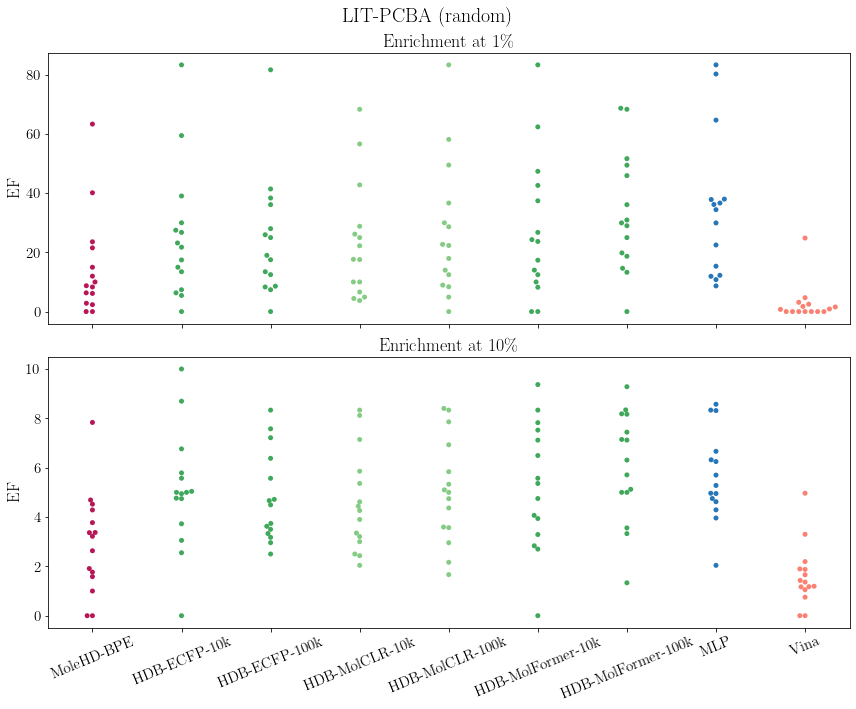

In [8]:
random_df = compute_model_metric_df(dataset="lit-pcba", split="random", target_list="all")